# Plant Disease Detection 



## 1. Imports laibaries

In [4]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## 2. Data Loading and Preprocessing

In [5]:
# Define data directories
data_dir = "PlantVillage"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# Define image transformations
def get_transforms(img_size=224):
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transforms, val_transforms

# Load datasets
def load_data(batch_size=32, img_size=224):
    train_transforms, val_transforms = get_transforms(img_size)
    
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    class_names = train_dataset.classes
    num_classes = len(class_names)
    
    return train_loader, val_loader, class_names, num_classes

# Load data with default parameters
batch_size = 32
train_loader, val_loader, class_names, num_classes = load_data(batch_size=batch_size)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")

Number of classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotte

## 3. CNN Model Architecture

In [6]:
class PlantDiseaseModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, num_conv_layers=4, num_dense_layers=2):
        super(PlantDiseaseModel, self).__init__()
        
        # Define convolutional layers
        self.conv_layers = nn.ModuleList()
        
        # First conv layer
        self.conv_layers.append(nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ))
        
        # Additional conv layers
        in_channels = 32
        for i in range(1, num_conv_layers):
            out_channels = in_channels * 2
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2)
            ))
            in_channels = out_channels
        
        # Calculate the size of the flattened features
        # Starting with 224x224 images, after 4 max pooling layers: 224/(2^4) = 14
        feature_size = (224 // (2 ** num_conv_layers)) ** 2 * in_channels
        
        # Define fully connected layers
        self.fc_layers = nn.ModuleList()
        
        # First FC layer
        self.fc_layers.append(nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        ))
        
        # Additional FC layers
        in_features = 512
        for i in range(1, num_dense_layers):
            out_features = in_features // 2
            self.fc_layers.append(nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            in_features = out_features
        
        # Output layer
        self.output_layer = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        # Pass through conv layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Pass through FC layers
        for fc_layer in self.fc_layers:
            x = fc_layer(x)
        
        # Output layer
        x = self.output_layer(x)
        
        return x

## 4. Training and Validation Functions

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0
    best_model_wts = None
    
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accs.append(epoch_acc.item())
        
        # Save best model
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            best_model_wts = model.state_dict().copy()
        
        time_elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} completed in {time_elapsed:.2f}s")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")
        print("-" * 50)
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

## 5. Particle Swarm Optimization (PSO) for Hyperparameter Tuning

In [8]:
class Particle:
    def __init__(self, bounds):
        # Initialize particle position and velocity
        self.position = {}
        self.velocity = {}
        self.best_position = {}
        self.best_fitness = float('-inf')
        
        # Initialize position and velocity within bounds
        for param, (min_val, max_val) in bounds.items():
            if isinstance(min_val, int) and isinstance(max_val, int):
                self.position[param] = random.randint(min_val, max_val)
                self.velocity[param] = random.randint(-1, 1)
            else:
                self.position[param] = random.uniform(min_val, max_val)
                self.velocity[param] = random.uniform(-0.1, 0.1)
            
            self.best_position[param] = self.position[param]

class PSO:
    def __init__(self, bounds, num_particles=5, max_iter=5, w=0.5, c1=1, c2=2):
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive weight
        self.c2 = c2  # Social weight
        
        # Initialize particles
        self.particles = [Particle(bounds) for _ in range(num_particles)]
        self.global_best_position = None
        self.global_best_fitness = float('-inf')
        
        # History for visualization
        self.history = []
    
    def update_particle(self, particle):
        for param in self.bounds.keys():
            # Update velocity
            r1, r2 = random.random(), random.random()
            cognitive = self.c1 * r1 * (particle.best_position[param] - particle.position[param])
            social = self.c2 * r2 * (self.global_best_position[param] - particle.position[param])
            particle.velocity[param] = self.w * particle.velocity[param] + cognitive + social
            
            # Update position
            particle.position[param] += particle.velocity[param]
            
            # Ensure position is within bounds
            min_val, max_val = self.bounds[param]
            particle.position[param] = max(min_val, min(max_val, particle.position[param]))
            
            # Round to integer if the parameter should be an integer
            if isinstance(min_val, int) and isinstance(max_val, int):
                particle.position[param] = int(round(particle.position[param]))
    
    def optimize(self, fitness_function):
        for iteration in range(self.max_iter):
            print(f"PSO Iteration {iteration+1}/{self.max_iter}")
            
            for i, particle in enumerate(self.particles):
                # Evaluate fitness
                fitness = fitness_function(particle.position)
                print(f"Particle {i+1}: {particle.position}, Fitness: {fitness:.4f}")
                
                # Update particle's best position
                if fitness > particle.best_fitness:
                    particle.best_fitness = fitness
                    particle.best_position = particle.position.copy()
                
                # Update global best position
                if fitness > self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = particle.position.copy()
            
            # Save history
            self.history.append({
                'iteration': iteration,
                'global_best_position': self.global_best_position.copy(),
                'global_best_fitness': self.global_best_fitness
            })
            
            # Update particles
            for particle in self.particles:
                self.update_particle(particle)
            
            print(f"Global best: {self.global_best_position}, Fitness: {self.global_best_fitness:.4f}")
            print("-" * 50)
        
        return self.global_best_position, self.global_best_fitness, self.history

def evaluate_hyperparameters(hyperparams):
    # Extract hyperparameters
    batch_size = hyperparams['batch_size']
    learning_rate = hyperparams['learning_rate']
    dropout_rate = hyperparams['dropout_rate']
    num_conv_layers = hyperparams['num_conv_layers']
    num_dense_layers = hyperparams['num_dense_layers']
    num_epochs = 3  # Use fewer epochs for optimization
    
    # Load data with current batch size
    train_loader, val_loader, _, _ = load_data(batch_size=batch_size)
    
    # Create model with current hyperparameters
    model = PlantDiseaseModel(
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        num_conv_layers=num_conv_layers,
        num_dense_layers=num_dense_layers
    ).to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    _, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
    
    # Return validation accuracy as fitness
    return metrics['best_val_acc']

# Define hyperparameter bounds for PSO
hyperparameter_bounds = {
    'batch_size': (16, 64),
    'learning_rate': (0.0001, 0.01),
    'dropout_rate': (0.2, 0.7),
    'num_conv_layers': (3, 5),
    'num_dense_layers': (1, 3)
}

## 6. Train Base Model

In [9]:
# Define base hyperparameters
base_hyperparams = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'dropout_rate': 0.5,
    'num_conv_layers': 4,
    'num_dense_layers': 2,
    'num_epochs': 10
}

# Load data with base batch size
train_loader, val_loader, _, _ = load_data(batch_size=base_hyperparams['batch_size'])

# Create base model
base_model = PlantDiseaseModel(
    num_classes=num_classes,
    dropout_rate=base_hyperparams['dropout_rate'],
    num_conv_layers=base_hyperparams['num_conv_layers'],
    num_dense_layers=base_hyperparams['num_dense_layers']
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=base_hyperparams['learning_rate'])

# Train base model
print("Training base model...")
base_model, base_metrics = train_model(
    base_model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs=base_hyperparams['num_epochs']
)

# Save base model
torch.save(base_model.state_dict(), 'base_model.pt')
print(f"Base model saved with validation accuracy: {base_metrics['best_val_acc']:.4f}")

Training base model...


Epoch 1/10 [Train]:   0%|          | 0/1358 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 7. Optimize Model with PSO

In [ ]:
# Initialize PSO
pso = PSO(
    bounds=hyperparameter_bounds,
    num_particles=5,
    max_iter=5,
    w=0.5,
    c1=1.5,
    c2=1.5
)

# Run PSO optimization
print("Running PSO optimization...")
best_hyperparams, best_fitness, history = pso.optimize(evaluate_hyperparameters)

print("\nBest hyperparameters found:")
for param, value in best_hyperparams.items():
    print(f"{param}: {value}")
print(f"Best validation accuracy: {best_fitness:.4f}")

Running PSO optimization...
PSO Iteration 1/5


Epoch 1/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/3 completed in 1660.90s
Train Loss: 1.8320, Train Acc: 0.4981
Val Loss: 0.8708, Val Acc: 0.7341
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/3 completed in 1656.74s
Train Loss: 0.9463, Train Acc: 0.7185
Val Loss: 0.4849, Val Acc: 0.8515
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/3 completed in 1653.62s
Train Loss: 0.6940, Train Acc: 0.7890
Val Loss: 0.3935, Val Acc: 0.8764
--------------------------------------------------
Particle 1: {'batch_size': 56, 'learning_rate': 0.00034760647670440266, 'dropout_rate': 0.3116053690744114, 'num_conv_layers': 5, 'num_dense_layers': 3}, Fitness: 0.8764


Epoch 1/3 [Train]:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 1/3 completed in 1670.19s
Train Loss: 1.8518, Train Acc: 0.4855
Val Loss: 0.9674, Val Acc: 0.7065
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 2/3 completed in 1682.19s
Train Loss: 1.0035, Train Acc: 0.6995
Val Loss: 0.5699, Val Acc: 0.8283
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/820 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 3/3 completed in 1674.17s
Train Loss: 0.7329, Train Acc: 0.7774
Val Loss: 0.4770, Val Acc: 0.8410
--------------------------------------------------
Particle 2: {'batch_size': 53, 'learning_rate': 0.0004146485268696576, 'dropout_rate': 0.3163304466953698, 'num_conv_layers': 5, 'num_dense_layers': 3}, Fitness: 0.8410


Epoch 1/3 [Train]:   0%|          | 0/725 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1/3 completed in 2046.86s
Train Loss: 3.6544, Train Acc: 0.2036
Val Loss: 2.4858, Val Acc: 0.2651
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/725 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 2/3 completed in 2045.29s
Train Loss: 2.8434, Train Acc: 0.2109
Val Loss: 2.5301, Val Acc: 0.2409
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/725 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 3/3 completed in 2052.81s
Train Loss: 2.8830, Train Acc: 0.2095
Val Loss: 2.4816, Val Acc: 0.2628
--------------------------------------------------
Particle 3: {'batch_size': 60, 'learning_rate': 0.004253246227520422, 'dropout_rate': 0.3390953541153313, 'num_conv_layers': 3, 'num_dense_layers': 2}, Fitness: 0.2651


Epoch 1/3 [Train]:   0%|          | 0/1317 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/330 [00:00<?, ?it/s]

Epoch 1/3 completed in 1065.26s
Train Loss: 2.4721, Train Acc: 0.3261
Val Loss: 1.6026, Val Acc: 0.5256
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/1317 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/330 [00:00<?, ?it/s]

Epoch 2/3 completed in 1064.67s
Train Loss: 1.7609, Train Acc: 0.4989
Val Loss: 1.1378, Val Acc: 0.6746
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/1317 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/330 [00:00<?, ?it/s]

Epoch 3/3 completed in 1064.17s
Train Loss: 1.4624, Train Acc: 0.5823
Val Loss: 0.9143, Val Acc: 0.7369
--------------------------------------------------
Particle 4: {'batch_size': 33, 'learning_rate': 0.002231606244865129, 'dropout_rate': 0.25110513825992437, 'num_conv_layers': 4, 'num_dense_layers': 3}, Fitness: 0.7369


Epoch 1/3 [Train]:   0%|          | 0/2414 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/604 [00:00<?, ?it/s]

Epoch 1/3 completed in 199.64s
Train Loss: 3.6376, Train Acc: 0.0984
Val Loss: 3.3469, Val Acc: 0.1015
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/2414 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/604 [00:00<?, ?it/s]

Epoch 2/3 completed in 199.58s
Train Loss: 3.3508, Train Acc: 0.0990
Val Loss: 3.3453, Val Acc: 0.1015
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/2414 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/604 [00:00<?, ?it/s]

Epoch 3/3 completed in 199.55s
Train Loss: 3.3469, Train Acc: 0.0995
Val Loss: 3.3457, Val Acc: 0.1015
--------------------------------------------------
Particle 5: {'batch_size': 18, 'learning_rate': 0.004648306308751242, 'dropout_rate': 0.6611476860140799, 'num_conv_layers': 4, 'num_dense_layers': 3}, Fitness: 0.1015
Global best: {'batch_size': 56, 'learning_rate': 0.00034760647670440266, 'dropout_rate': 0.3116053690744114, 'num_conv_layers': 5, 'num_dense_layers': 3}, Fitness: 0.8764
--------------------------------------------------
PSO Iteration 2/5


Epoch 1/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/3 completed in 1658.57s
Train Loss: 1.5225, Train Acc: 0.5775
Val Loss: 0.5533, Val Acc: 0.8391
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/3 completed in 1676.47s
Train Loss: 0.7137, Train Acc: 0.7813
Val Loss: 0.3547, Val Acc: 0.8890
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/3 completed in 1821.44s
Train Loss: 0.4884, Train Acc: 0.8473
Val Loss: 0.2099, Val Acc: 0.9335
--------------------------------------------------
Particle 1: {'batch_size': 56, 'learning_rate': 0.0001, 'dropout_rate': 0.3352524904908126, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9335


Epoch 1/3 [Train]:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 1/3 completed in 2725.08s
Train Loss: 2.0527, Train Acc: 0.4514
Val Loss: 0.9671, Val Acc: 0.7337
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 2/3 completed in 3454.25s
Train Loss: 1.1533, Train Acc: 0.6648
Val Loss: 0.5507, Val Acc: 0.8330
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 3/3 completed in 1478.72s
Train Loss: 0.8408, Train Acc: 0.7504
Val Loss: 0.4227, Val Acc: 0.8691
--------------------------------------------------
Particle 2: {'batch_size': 55, 'learning_rate': 0.0001, 'dropout_rate': 0.32193929335574106, 'num_conv_layers': 4, 'num_dense_layers': 3}, Fitness: 0.8691


Epoch 1/3 [Train]:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 1/3 completed in 928.20s
Train Loss: 1.6165, Train Acc: 0.5550
Val Loss: 0.6676, Val Acc: 0.8046
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 2/3 completed in 877.51s
Train Loss: 0.8843, Train Acc: 0.7350
Val Loss: 0.4178, Val Acc: 0.8701
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/790 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 3/3 completed in 896.14s
Train Loss: 0.6744, Train Acc: 0.7933
Val Loss: 0.3079, Val Acc: 0.9053
--------------------------------------------------
Particle 3: {'batch_size': 55, 'learning_rate': 0.0001, 'dropout_rate': 0.34127040617803195, 'num_conv_layers': 4, 'num_dense_layers': 2}, Fitness: 0.9053


Epoch 1/3 [Train]:   0%|          | 0/1087 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/272 [00:00<?, ?it/s]

Epoch 1/3 completed in 581.54s
Train Loss: 3.4125, Train Acc: 0.1380
Val Loss: 3.1038, Val Acc: 0.1849
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/1087 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/272 [00:00<?, ?it/s]

Epoch 2/3 completed in 580.90s
Train Loss: 3.3098, Train Acc: 0.1230
Val Loss: 3.3464, Val Acc: 0.1015
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/1087 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/272 [00:00<?, ?it/s]

Epoch 3/3 completed in 587.97s
Train Loss: 3.3471, Train Acc: 0.1005
Val Loss: 3.3459, Val Acc: 0.0986
--------------------------------------------------
Particle 4: {'batch_size': 40, 'learning_rate': 0.01, 'dropout_rate': 0.29857915412627745, 'num_conv_layers': 5, 'num_dense_layers': 3}, Fitness: 0.1849


Epoch 1/3 [Train]:   0%|          | 0/869 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 1/3 completed in 689.36s
Train Loss: 2.2651, Train Acc: 0.4006
Val Loss: 1.2130, Val Acc: 0.6559
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/869 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 2/3 completed in 649.20s
Train Loss: 1.3156, Train Acc: 0.6252
Val Loss: 0.6859, Val Acc: 0.7915
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/869 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/218 [00:00<?, ?it/s]

Epoch 3/3 completed in 689.60s
Train Loss: 0.9421, Train Acc: 0.7204
Val Loss: 0.4451, Val Acc: 0.8668
--------------------------------------------------
Particle 5: {'batch_size': 50, 'learning_rate': 0.0001, 'dropout_rate': 0.40961663889145306, 'num_conv_layers': 5, 'num_dense_layers': 3}, Fitness: 0.8668
Global best: {'batch_size': 56, 'learning_rate': 0.0001, 'dropout_rate': 0.3352524904908126, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9335
--------------------------------------------------
PSO Iteration 3/5


Epoch 1/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/3 completed in 938.55s
Train Loss: 1.4960, Train Acc: 0.5832
Val Loss: 0.5450, Val Acc: 0.8426
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/3 completed in 946.87s
Train Loss: 0.7009, Train Acc: 0.7846
Val Loss: 0.3214, Val Acc: 0.9001
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/3 completed in 1036.09s
Train Loss: 0.4725, Train Acc: 0.8525
Val Loss: 0.2172, Val Acc: 0.9325
--------------------------------------------------
Particle 1: {'batch_size': 56, 'learning_rate': 0.0001, 'dropout_rate': 0.34707605119901325, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9325


Epoch 1/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/3 completed in 914.28s
Train Loss: 2.0613, Train Acc: 0.4512
Val Loss: 0.9805, Val Acc: 0.7213
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/3 completed in 932.71s
Train Loss: 1.1584, Train Acc: 0.6657
Val Loss: 0.5994, Val Acc: 0.8207
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/3 completed in 1020.47s
Train Loss: 0.8574, Train Acc: 0.7474
Val Loss: 0.4501, Val Acc: 0.8599
--------------------------------------------------
Particle 2: {'batch_size': 56, 'learning_rate': 0.0001, 'dropout_rate': 0.33007216121758837, 'num_conv_layers': 4, 'num_dense_layers': 3}, Fitness: 0.8599


Epoch 1/3 [Train]:   0%|          | 0/805 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/202 [00:00<?, ?it/s]

Epoch 1/3 completed in 778.18s
Train Loss: 1.5430, Train Acc: 0.5718
Val Loss: 0.6307, Val Acc: 0.8055
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/805 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/202 [00:00<?, ?it/s]

Epoch 2/3 completed in 755.67s
Train Loss: 0.7086, Train Acc: 0.7828
Val Loss: 0.3148, Val Acc: 0.9071
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/805 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/202 [00:00<?, ?it/s]

Epoch 3/3 completed in 752.63s
Train Loss: 0.4801, Train Acc: 0.8502
Val Loss: 0.2085, Val Acc: 0.9321
--------------------------------------------------
Particle 3: {'batch_size': 54, 'learning_rate': 0.0001, 'dropout_rate': 0.33411975612290284, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9321


Epoch 1/3 [Train]:   0%|          | 0/725 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 1/3 completed in 1389.58s
Train Loss: 3.2380, Train Acc: 0.2044
Val Loss: 2.5372, Val Acc: 0.2478
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/725 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 2/3 completed in 1269.78s
Train Loss: 2.8310, Train Acc: 0.2204
Val Loss: 2.4912, Val Acc: 0.2742
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/725 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch 3/3 completed in 1253.09s
Train Loss: 2.6764, Train Acc: 0.2398
Val Loss: 2.3029, Val Acc: 0.3358
--------------------------------------------------
Particle 4: {'batch_size': 60, 'learning_rate': 0.004088632904990842, 'dropout_rate': 0.28458059409519376, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.3358


Epoch 1/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 1/3 completed in 1431.49s
Train Loss: 1.4125, Train Acc: 0.6095
Val Loss: 0.5672, Val Acc: 0.8252
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 2/3 completed in 1295.43s
Train Loss: 0.6378, Train Acc: 0.8034
Val Loss: 0.2954, Val Acc: 0.9089
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 3/3 completed in 1286.91s
Train Loss: 0.4224, Train Acc: 0.8680
Val Loss: 0.2144, Val Acc: 0.9309
--------------------------------------------------
Particle 5: {'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.2742967962992353, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9309
Global best: {'batch_size': 56, 'learning_rate': 0.0001, 'dropout_rate': 0.3352524904908126, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9335
--------------------------------------------------
PSO Iteration 4/5


Epoch 1/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/3 completed in 830.42s
Train Loss: 1.5297, Train Acc: 0.5735
Val Loss: 0.6353, Val Acc: 0.8124
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/3 completed in 793.19s
Train Loss: 0.7339, Train Acc: 0.7757
Val Loss: 0.3097, Val Acc: 0.9060
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/3 completed in 833.20s
Train Loss: 0.5018, Train Acc: 0.8424
Val Loss: 0.2022, Val Acc: 0.9342
--------------------------------------------------
Particle 1: {'batch_size': 56, 'learning_rate': 0.0001, 'dropout_rate': 0.3300104383295839, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9342


Epoch 1/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/3 completed in 875.01s
Train Loss: 1.5968, Train Acc: 0.5577
Val Loss: 0.6252, Val Acc: 0.8149
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/3 completed in 808.54s
Train Loss: 0.8501, Train Acc: 0.7441
Val Loss: 0.3877, Val Acc: 0.8803
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/776 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/3 completed in 883.96s
Train Loss: 0.6290, Train Acc: 0.8052
Val Loss: 0.3388, Val Acc: 0.8931
--------------------------------------------------
Particle 2: {'batch_size': 56, 'learning_rate': 0.0001, 'dropout_rate': 0.3287647936301306, 'num_conv_layers': 4, 'num_dense_layers': 2}, Fitness: 0.8931


Epoch 1/3 [Train]:   0%|          | 0/805 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/202 [00:00<?, ?it/s]

Epoch 1/3 completed in 813.63s
Train Loss: 1.4953, Train Acc: 0.5820
Val Loss: 0.5662, Val Acc: 0.8296
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/805 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/202 [00:00<?, ?it/s]

Epoch 2/3 completed in 796.14s
Train Loss: 0.7294, Train Acc: 0.7755
Val Loss: 0.3699, Val Acc: 0.8843
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/805 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/202 [00:00<?, ?it/s]

Epoch 3/3 completed in 841.07s
Train Loss: 0.5126, Train Acc: 0.8390
Val Loss: 0.2373, Val Acc: 0.9262
--------------------------------------------------
Particle 3: {'batch_size': 54, 'learning_rate': 0.0001, 'dropout_rate': 0.33200503893794725, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9262


Epoch 1/3 [Train]:   0%|          | 0/737 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 1/3 completed in 1402.51s
Train Loss: 1.4132, Train Acc: 0.6046
Val Loss: 0.5155, Val Acc: 0.8444
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/737 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 2/3 completed in 1797.27s
Train Loss: 0.6558, Train Acc: 0.7976
Val Loss: 0.3028, Val Acc: 0.9048
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/737 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/185 [00:00<?, ?it/s]

Epoch 3/3 completed in 1619.87s
Train Loss: 0.4471, Train Acc: 0.8589
Val Loss: 0.2072, Val Acc: 0.9309
--------------------------------------------------
Particle 4: {'batch_size': 59, 'learning_rate': 0.0001, 'dropout_rate': 0.2995591810675494, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9309


Epoch 1/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 1/3 completed in 1298.36s
Train Loss: 1.0420, Train Acc: 0.6978
Val Loss: 0.4477, Val Acc: 0.8602
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 2/3 completed in 1315.15s
Train Loss: 0.4467, Train Acc: 0.8589
Val Loss: 0.2450, Val Acc: 0.9219
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 3/3 completed in 1339.53s
Train Loss: 0.3139, Train Acc: 0.8990
Val Loss: 0.1792, Val Acc: 0.9422
--------------------------------------------------
Particle 5: {'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.24344996462339646, 'num_conv_layers': 5, 'num_dense_layers': 1}, Fitness: 0.9422
Global best: {'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.24344996462339646, 'num_conv_layers': 5, 'num_dense_layers': 1}, Fitness: 0.9422
--------------------------------------------------
PSO Iteration 5/5


Epoch 1/3 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 1/3 completed in 1373.46s
Train Loss: 1.0774, Train Acc: 0.6902
Val Loss: 0.4905, Val Acc: 0.8502
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 2/3 completed in 1363.34s
Train Loss: 0.4720, Train Acc: 0.8516
Val Loss: 0.2543, Val Acc: 0.9205
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 3/3 completed in 1370.28s
Train Loss: 0.3315, Train Acc: 0.8930
Val Loss: 0.1750, Val Acc: 0.9453
--------------------------------------------------
Particle 1: {'batch_size': 61, 'learning_rate': 0.0001, 'dropout_rate': 0.2639412210864647, 'num_conv_layers': 5, 'num_dense_layers': 1}, Fitness: 0.9453


Epoch 1/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 1/3 completed in 1318.75s
Train Loss: 1.1201, Train Acc: 0.6804
Val Loss: 0.4533, Val Acc: 0.8603
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 2/3 completed in 1315.80s
Train Loss: 0.4972, Train Acc: 0.8458
Val Loss: 0.2634, Val Acc: 0.9178
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 3/3 completed in 1313.75s
Train Loss: 0.3377, Train Acc: 0.8909
Val Loss: 0.1804, Val Acc: 0.9414
--------------------------------------------------
Particle 2: {'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.2659625254717028, 'num_conv_layers': 5, 'num_dense_layers': 1}, Fitness: 0.9414


Epoch 1/3 [Train]:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/3 completed in 1315.11s
Train Loss: 1.2579, Train Acc: 0.6427
Val Loss: 0.4811, Val Acc: 0.8536
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/3 completed in 1301.90s
Train Loss: 0.5536, Train Acc: 0.8272
Val Loss: 0.2941, Val Acc: 0.9073
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3/3 completed in 1341.13s
Train Loss: 0.3775, Train Acc: 0.8786
Val Loss: 0.1745, Val Acc: 0.9422
--------------------------------------------------
Particle 3: {'batch_size': 58, 'learning_rate': 0.0001, 'dropout_rate': 0.20512648990201363, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9422


Epoch 1/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 1/3 completed in 1319.13s
Train Loss: 1.5032, Train Acc: 0.5813
Val Loss: 0.6070, Val Acc: 0.8159
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 2/3 completed in 1330.80s
Train Loss: 0.7178, Train Acc: 0.7815
Val Loss: 0.3118, Val Acc: 0.9069
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 3/3 completed in 1317.18s
Train Loss: 0.4919, Train Acc: 0.8456
Val Loss: 0.2237, Val Acc: 0.9305
--------------------------------------------------
Particle 4: {'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.3022372265477447, 'num_conv_layers': 5, 'num_dense_layers': 2}, Fitness: 0.9305


Epoch 1/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 1/3 completed in 1309.01s
Train Loss: 1.0768, Train Acc: 0.6919
Val Loss: 0.4005, Val Acc: 0.8819
--------------------------------------------------


Epoch 2/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 2/3 completed in 1316.73s
Train Loss: 0.4660, Train Acc: 0.8531
Val Loss: 0.2580, Val Acc: 0.9176
--------------------------------------------------


Epoch 3/3 [Train]:   0%|          | 0/679 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/170 [00:00<?, ?it/s]

Epoch 3/3 completed in 1308.20s
Train Loss: 0.3150, Train Acc: 0.8979
Val Loss: 0.1983, Val Acc: 0.9360
--------------------------------------------------
Particle 5: {'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.22802654878547704, 'num_conv_layers': 5, 'num_dense_layers': 1}, Fitness: 0.9360
Global best: {'batch_size': 61, 'learning_rate': 0.0001, 'dropout_rate': 0.2639412210864647, 'num_conv_layers': 5, 'num_dense_layers': 1}, Fitness: 0.9453
--------------------------------------------------

Best hyperparameters found:
batch_size: 61
learning_rate: 0.0001
dropout_rate: 0.2639412210864647
num_conv_layers: 5
num_dense_layers: 1
Best validation accuracy: 0.9453


## 8. Train Optimized Model


In [ ]:
# Add number of epochs to best hyperparameters
best_hyperparams['num_epochs'] = 15
#best_hyperparams['patience'] = 5  # Early stopping patience

# Load data with optimized batch size
train_loader, val_loader, _, _ = load_data(batch_size=best_hyperparams['batch_size'])

# Create optimized model
optimized_model = PlantDiseaseModel(
    num_classes=num_classes,
    dropout_rate=best_hyperparams['dropout_rate'],
    num_conv_layers=best_hyperparams['num_conv_layers'],
    num_dense_layers=best_hyperparams['num_dense_layers']
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(optimized_model.parameters(), lr=best_hyperparams['learning_rate'])

# Train optimized model with early stopping
print("Training optimized model...")
optimized_model, optimized_metrics = train_model(
    optimized_model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs=best_hyperparams['num_epochs'],
   # patience=best_hyperparams['patience']  # Pass patience parameter to train_model
)

# Save optimized model
torch.save(optimized_model.state_dict(), 'optimized_model.pt')
print(f"Optimized model saved with validation accuracy: {optimized_metrics['best_val_acc']:.4f}")

Training optimized model...


Epoch 1/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 1/15 completed in 1428.98s
Train Loss: 1.0875, Train Acc: 0.6849
Val Loss: 0.4289, Val Acc: 0.8648
--------------------------------------------------


Epoch 2/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 2/15 completed in 1363.49s
Train Loss: 0.4908, Train Acc: 0.8431
Val Loss: 0.2615, Val Acc: 0.9170
--------------------------------------------------


Epoch 3/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 3/15 completed in 1423.41s
Train Loss: 0.3395, Train Acc: 0.8906
Val Loss: 0.1897, Val Acc: 0.9385
--------------------------------------------------


Epoch 4/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 4/15 completed in 1190.95s
Train Loss: 0.2573, Train Acc: 0.9162
Val Loss: 0.1402, Val Acc: 0.9541
--------------------------------------------------


Epoch 5/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 5/15 completed in 1319.96s
Train Loss: 0.2147, Train Acc: 0.9290
Val Loss: 0.1195, Val Acc: 0.9598
--------------------------------------------------


Epoch 6/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 6/15 completed in 1176.64s
Train Loss: 0.1801, Train Acc: 0.9400
Val Loss: 0.1062, Val Acc: 0.9642
--------------------------------------------------


Epoch 7/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 7/15 completed in 1143.37s
Train Loss: 0.1555, Train Acc: 0.9486
Val Loss: 0.1485, Val Acc: 0.9512
--------------------------------------------------


Epoch 8/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 8/15 completed in 1161.24s
Train Loss: 0.1409, Train Acc: 0.9527
Val Loss: 0.0851, Val Acc: 0.9715
--------------------------------------------------


Epoch 9/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 9/15 completed in 1162.22s
Train Loss: 0.1298, Train Acc: 0.9551
Val Loss: 0.0793, Val Acc: 0.9742
--------------------------------------------------


Epoch 10/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 10/15 completed in 1159.83s
Train Loss: 0.1127, Train Acc: 0.9628
Val Loss: 0.0648, Val Acc: 0.9791
--------------------------------------------------


Epoch 11/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 11/15 completed in 1164.32s
Train Loss: 0.1086, Train Acc: 0.9634
Val Loss: 0.1097, Val Acc: 0.9653
--------------------------------------------------


Epoch 12/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 12/15 completed in 1168.22s
Train Loss: 0.0967, Train Acc: 0.9671
Val Loss: 0.0644, Val Acc: 0.9787
--------------------------------------------------


Epoch 13/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 13/15 completed in 1180.14s
Train Loss: 0.0929, Train Acc: 0.9681
Val Loss: 0.0625, Val Acc: 0.9791
--------------------------------------------------


Epoch 14/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 14/15 completed in 1178.90s
Train Loss: 0.0816, Train Acc: 0.9720
Val Loss: 0.0578, Val Acc: 0.9819
--------------------------------------------------


Epoch 15/15 [Train]:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 15/15 completed in 1180.50s
Train Loss: 0.0784, Train Acc: 0.9730
Val Loss: 0.0620, Val Acc: 0.9785
--------------------------------------------------
Optimized model saved with validation accuracy: 0.9819


## 9. Compare Base and Optimized Models

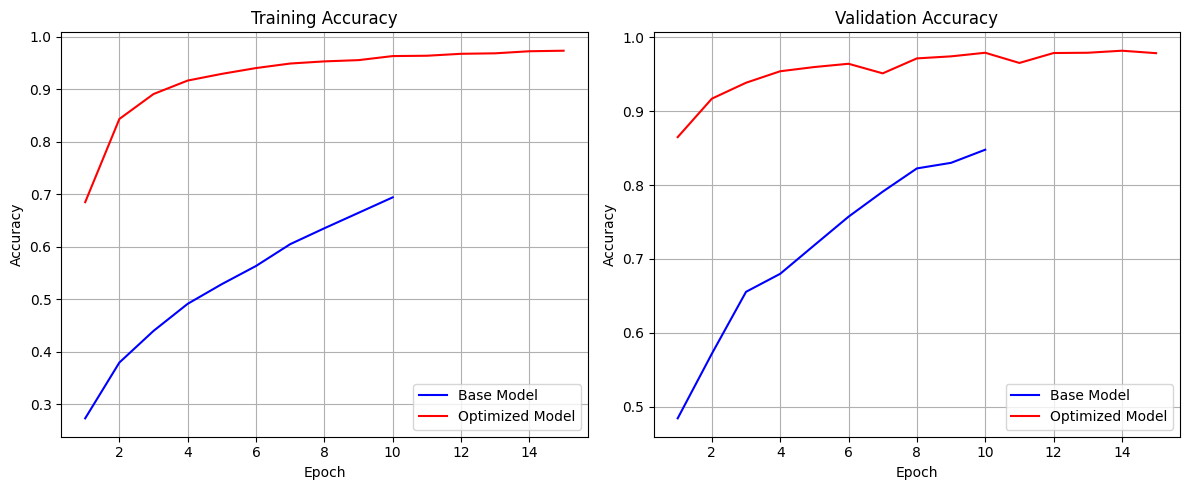

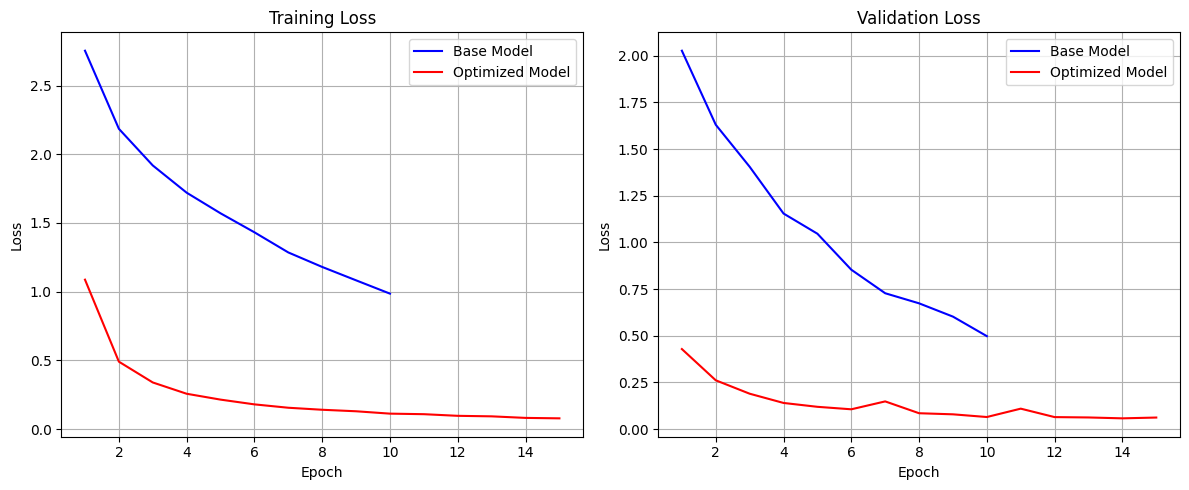

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(base_metrics['train_accs']) + 1), base_metrics['train_accs'], 'b-', label='Base Model')
plt.plot(range(1, len(optimized_metrics['train_accs']) + 1), optimized_metrics['train_accs'], 'r-', label='Optimized Model')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(base_metrics['val_accs']) + 1), base_metrics['val_accs'], 'b-', label='Base Model')
plt.plot(range(1, len(optimized_metrics['val_accs']) + 1), optimized_metrics['val_accs'], 'r-', label='Optimized Model')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(base_metrics['train_losses']) + 1), base_metrics['train_losses'], 'b-', label='Base Model')
plt.plot(range(1, len(optimized_metrics['train_losses']) + 1), optimized_metrics['train_losses'], 'r-', label='Optimized Model')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(base_metrics['val_losses']) + 1), base_metrics['val_losses'], 'b-', label='Base Model')
plt.plot(range(1, len(optimized_metrics['val_losses']) + 1), optimized_metrics['val_losses'], 'r-', label='Optimized Model')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# Print comparison table
comparison_data = {
    'Model': ['Base Model', 'Optimized Model'],
    'Best Validation Accuracy': [
        base_metrics['best_val_acc'].cpu().item() if torch.is_tensor(base_metrics['best_val_acc']) else base_metrics['best_val_acc'], 
        optimized_metrics['best_val_acc'].cpu().item() if torch.is_tensor(optimized_metrics['best_val_acc']) else optimized_metrics['best_val_acc']
    ],
    'Final Training Accuracy': [base_metrics['train_accs'][-1], optimized_metrics['train_accs'][-1]],
    'Final Validation Accuracy': [base_metrics['val_accs'][-1], optimized_metrics['val_accs'][-1]],
    'Final Training Loss': [base_metrics['train_losses'][-1], optimized_metrics['train_losses'][-1]],
    'Final Validation Loss': [base_metrics['val_losses'][-1], optimized_metrics['val_losses'][-1]]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Model,Best Validation Accuracy,Final Training Accuracy,Final Validation Accuracy,Final Training Loss,Final Validation Loss
0,Base Model,0.847804,0.694043,0.847804,0.985837,0.498026
1,Optimized Model,0.981862,0.973000,0.978547,0.078428,0.062026


## 10. Launch the GUI Application

Loading models for 38 classes...

Loading base model:
Loaded hyperparameters from base_hyperparams.json:
  - dropout_rate: 0.5
  - num_conv_layers: 4
  - num_dense_layers: 2
Successfully loaded model weights from base_model.pt

Loading optimized model:
Loaded hyperparameters from optimized_hyperparams.json:
  - dropout_rate: 0.2639412210864647
  - num_conv_layers: 5
  - num_dense_layers: 1
Successfully loaded model weights from optimized_model.pt

Models loaded successfully. Starting GUI...


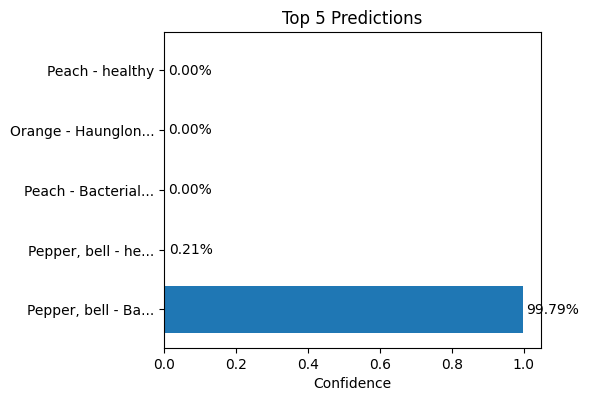

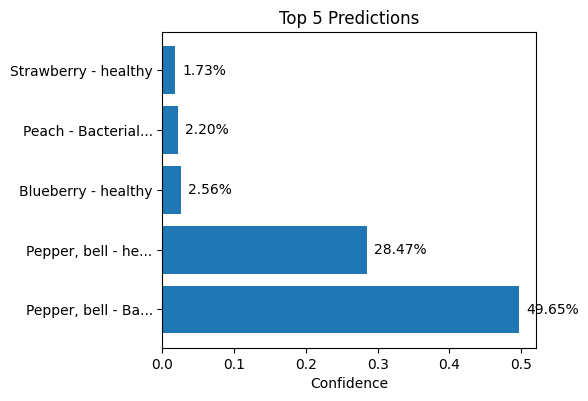

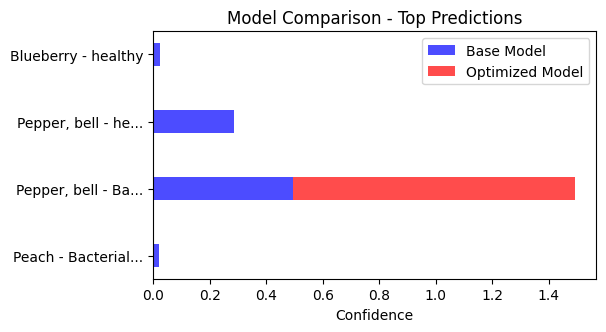

In [13]:
import json
import os

# Function to load model from file
def load_model_from_file(model_path, num_classes, hyperparams_path=None):
    """Load a model from a saved file with specified hyperparameters"""
    
    # Load hyperparameters from JSON if provided
    if hyperparams_path and os.path.exists(hyperparams_path):
        with open(hyperparams_path, 'r') as f:
            hyperparams = json.load(f)
        
        # Extract model architecture parameters
        dropout_rate = hyperparams.get('dropout_rate', 0.5)
        num_conv_layers = hyperparams.get('num_conv_layers', 4)
        num_dense_layers = hyperparams.get('num_dense_layers', 2)
        print(f"Loaded hyperparameters from {hyperparams_path}:")
        print(f"  - dropout_rate: {dropout_rate}")
        print(f"  - num_conv_layers: {num_conv_layers}")
        print(f"  - num_dense_layers: {num_dense_layers}")
    else:
        # Default parameters if JSON not found
        dropout_rate = 0.5
        num_conv_layers = 4
        num_dense_layers = 2
        print(f"Using default hyperparameters (JSON file not found)")
    
    # Create model with the appropriate architecture
    model = PlantDiseaseModel(
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        num_conv_layers=num_conv_layers,
        num_dense_layers=num_dense_layers
    ).to(device)
    
    # Load weights if model file exists
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        print(f"Successfully loaded model weights from {model_path}")
    else:
        print(f"Warning: Model file {model_path} not found. Using untrained model.")
    
    return model

# Try to load the models from saved files
try:
    # Get class names if not already defined
    if 'class_names' not in globals():
        train_dir = os.path.join("PlantVillage", "train")
        if os.path.exists(train_dir):
            class_names = sorted(os.listdir(train_dir))
            num_classes = len(class_names)
        else:
            print("Warning: Training directory not found. Using default class names.")
            class_names = ["Class_" + str(i) for i in range(38)]  # Default to 38 classes
            num_classes = 38
    else:
        num_classes = len(class_names)
    
    print(f"Loading models for {num_classes} classes...")
    
    # Load base model
    print("\nLoading base model:")
    base_model_path = 'base_model.pt'
    base_hyperparams_path = 'base_hyperparams.json'
    base_model = load_model_from_file(base_model_path, num_classes, base_hyperparams_path)
    
    # Load optimized model
    print("\nLoading optimized model:")
    optimized_model_path = 'optimized_model.pt'
    optimized_hyperparams_path = 'optimized_hyperparams.json'
    optimized_model = load_model_from_file(optimized_model_path, num_classes, optimized_hyperparams_path)
    
    print("\nModels loaded successfully. Starting GUI...")
    
    # Create and run the GUI
    root = tk.Tk()
    app = ModelComparisonApp(root, base_model, optimized_model, class_names)
    root.mainloop()
    
except Exception as e:
    print(f"Error initializing the GUI: {str(e)}")
    print("Please make sure you have run the cells that train and save the models first.")